<a href="https://colab.research.google.com/github/sujitojha1/EVA8/blob/main/Session9/EVA8_S9_CIFAR10_custom_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement EVA 8, Session9 : CIFAR 10


## 1. Loading Module and Models 

In [166]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [167]:
# Future print function
from __future__ import print_function

# Load modules/models from EVA course
!rm -rf models
!git clone https://github.com/sujitojha1/pytorch-eva8 -q --quiet
!mv pytorch-eva8/* .
print("Loaded EVA8 Modules and Models")

!rm -rf pytorch-eva8

# Installing latest Albumentation library
!pip install -U git+https://github.com/albu/albumentations -q --quiet

!pip install torch_lr_finder -q --quiet

# For inline matplotlib plotting
%matplotlib inline

Loaded EVA8 Modules and Models
  Preparing metadata (setup.py) ... done



## 2. Loading train and test data with transforms and loader functions

In [168]:
from utils import *

# Loading test and train data & dataloader
cifar10 = dataset_cifar10(batch_size=512)

# Train dataloader
trainloader = cifar10.loader(train_flag=True)

# Test dataloader
testloader = cifar10.loader(train_flag=False)

classes = cifar10.classes

CUDA availability ? True
Files already downloaded and verified
Files already downloaded and verified


## 3. Exploratory Data Analysis

### 3.1 Summary Statistics

In [169]:
cifar10.data_summary_stats()
#print(vars(train))

Files already downloaded and verified
Files already downloaded and verified
(60000, 32, 32, 3)
[0.49186878 0.48265391 0.44717728]
[0.24697121 0.24338894 0.26159259]


### 3.2 Plotting sample images

Files already downloaded and verified


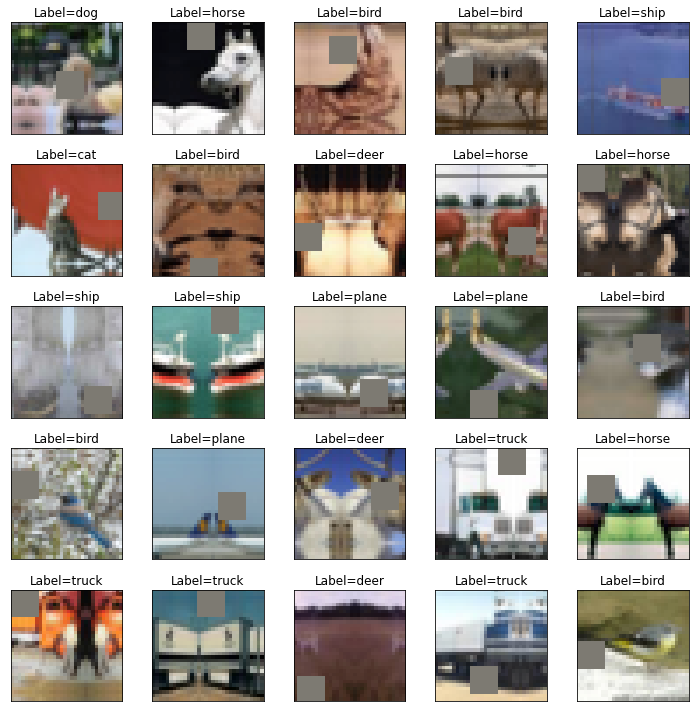

In [170]:
cifar10.sample_pictures(train_flag=True)

# The Model

In [187]:
from models.model9 import *
import torch

# Loading ResNet18 Model
net = net()

# Using cuda if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

# Sending network to device
net = net.to(device)

cuda


# Model Summary

In [188]:
!pip install torchsummary
from torchsummary import summary

# Model Summary
summary(net, input_size=(3, 32, 32))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             864
              GELU-2           [-1, 32, 30, 30]               0
       BatchNorm2d-3           [-1, 32, 30, 30]              64
            Conv2d-4          [-1, 256, 28, 28]          73,728
              GELU-5          [-1, 256, 28, 28]               0
       BatchNorm2d-6          [-1, 256, 28, 28]             512
            Conv2d-7           [-1, 48, 26, 26]         110,592
              GELU-8           [-1, 48, 26, 26]               0
       BatchNorm2d-9           [-1, 48, 26, 26]              96
AdaptiveAvgPool2d-10             [-1, 48, 1, 1]               0
           Linear-11                    [-1, 8]             392
           Linear-12                    [-1, 8]             392
    

## Find the LR for One Cycle Learning Rate

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.68E-02


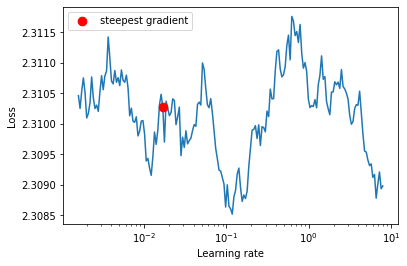

(<AxesSubplot:xlabel='Learning rate', ylabel='Loss'>, 0.01683180353330957)

In [189]:
import copy
from torch_lr_finder import LRFinder
import torch.nn as nn
import numpy as np

net_exp = copy.deepcopy(net)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(net_exp, optimizer, criterion, device=device)
lr_finder.range_test(trainloader, end_lr=10, num_iter=200)
lr_finder.plot()

In [190]:
min_loss = min(lr_finder.history['loss'])
ler_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print("Max LR is {}".format(ler_rate))

Max LR is 0.1175849554052157


# Training and Testing

In [191]:
# Load train and test model
from main import fit_model

optimizer = torch.optim.Adam(net.parameters(), lr=0.01, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=0.01,
                                                steps_per_epoch=len(trainloader), 
                                                epochs=24,
                                                pct_start=0.2,
                                                div_factor=25,
                                                three_phase=False, 
                                                final_div_factor=100,
                                                anneal_strategy='linear'
                                                ) #final_div_factor=100,
net, history = fit_model(
    net=net, device=device,
    criterion = nn.CrossEntropyLoss(),
    train_loader=trainloader, test_loader=testloader,
    optimizer=optimizer, 
    scheduler=scheduler, 
    NUM_EPOCHS=24
)

EPOCH: 1 (LR: 0.0004)


Batch_id=97 Loss=2.12701 Accuracy=15.70%: 100%|██████████| 98/98 [00:29<00:00,  3.32it/s]



Test set: Average loss: 1.9572, Accuracy: 1953/10000 (19.53%)

EPOCH: 2 (LR: 0.002404260758414998)


Batch_id=97 Loss=1.95919 Accuracy=20.02%: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]



Test set: Average loss: 1.8998, Accuracy: 2037/10000 (20.37%)

EPOCH: 3 (LR: 0.004408521516829996)


Batch_id=97 Loss=1.97520 Accuracy=19.43%: 100%|██████████| 98/98 [00:24<00:00,  4.01it/s]



Test set: Average loss: 3.5751, Accuracy: 1966/10000 (19.66%)

EPOCH: 4 (LR: 0.006412782275244994)


Batch_id=97 Loss=2.03821 Accuracy=18.83%: 100%|██████████| 98/98 [00:25<00:00,  3.89it/s]



Test set: Average loss: 1.9816, Accuracy: 2064/10000 (20.64%)

EPOCH: 5 (LR: 0.00841704303365999)


Batch_id=97 Loss=1.97588 Accuracy=19.17%: 100%|██████████| 98/98 [00:24<00:00,  3.97it/s]



Test set: Average loss: 2.0780, Accuracy: 1615/10000 (16.15%)

EPOCH: 6 (LR: 0.0098905625)


Batch_id=97 Loss=1.96379 Accuracy=19.30%: 100%|██████████| 98/98 [00:24<00:00,  3.98it/s]



Test set: Average loss: 1.9902, Accuracy: 1924/10000 (19.24%)

EPOCH: 7 (LR: 0.0093699375)


Batch_id=97 Loss=1.95342 Accuracy=19.30%: 100%|██████████| 98/98 [00:24<00:00,  3.99it/s]



Test set: Average loss: 2.1851, Accuracy: 1599/10000 (15.99%)

EPOCH: 8 (LR: 0.008849312500000001)


Batch_id=97 Loss=1.95224 Accuracy=19.71%: 100%|██████████| 98/98 [00:25<00:00,  3.89it/s]



Test set: Average loss: 1.9320, Accuracy: 2046/10000 (20.46%)

EPOCH: 9 (LR: 0.008328687500000001)


Batch_id=97 Loss=1.94273 Accuracy=19.69%: 100%|██████████| 98/98 [00:24<00:00,  3.96it/s]



Test set: Average loss: 1.9402, Accuracy: 2057/10000 (20.57%)

EPOCH: 10 (LR: 0.007808062500000001)


Batch_id=97 Loss=1.93590 Accuracy=20.17%: 100%|██████████| 98/98 [00:24<00:00,  3.98it/s]



Test set: Average loss: 2.2384, Accuracy: 2069/10000 (20.69%)

EPOCH: 11 (LR: 0.0072874375000000005)


Batch_id=97 Loss=1.95436 Accuracy=19.53%: 100%|██████████| 98/98 [00:24<00:00,  3.98it/s]



Test set: Average loss: 2.0006, Accuracy: 1947/10000 (19.47%)

EPOCH: 12 (LR: 0.0067668125)


Batch_id=97 Loss=1.92377 Accuracy=20.40%: 100%|██████████| 98/98 [00:24<00:00,  4.00it/s]



Test set: Average loss: 1.8654, Accuracy: 2237/10000 (22.37%)

EPOCH: 13 (LR: 0.0062461875)


Batch_id=97 Loss=1.92149 Accuracy=21.00%: 100%|██████████| 98/98 [00:24<00:00,  3.92it/s]



Test set: Average loss: 1.8893, Accuracy: 2052/10000 (20.52%)

EPOCH: 14 (LR: 0.005725562500000001)


Batch_id=97 Loss=1.91371 Accuracy=21.10%: 100%|██████████| 98/98 [00:24<00:00,  4.00it/s]



Test set: Average loss: 1.8542, Accuracy: 2155/10000 (21.55%)

EPOCH: 15 (LR: 0.005204937500000001)


Batch_id=97 Loss=1.90583 Accuracy=21.66%: 100%|██████████| 98/98 [00:24<00:00,  4.03it/s]



Test set: Average loss: 1.9225, Accuracy: 2040/10000 (20.40%)

EPOCH: 16 (LR: 0.0046843125)


Batch_id=97 Loss=1.90570 Accuracy=21.99%: 100%|██████████| 98/98 [00:24<00:00,  3.99it/s]



Test set: Average loss: 1.8613, Accuracy: 2361/10000 (23.61%)

EPOCH: 17 (LR: 0.0041636875)


Batch_id=97 Loss=1.89615 Accuracy=22.07%: 100%|██████████| 98/98 [00:24<00:00,  3.96it/s]



Test set: Average loss: 1.8398, Accuracy: 2325/10000 (23.25%)

EPOCH: 18 (LR: 0.0036430625000000005)


Batch_id=97 Loss=1.89108 Accuracy=22.68%: 100%|██████████| 98/98 [00:24<00:00,  4.00it/s]



Test set: Average loss: 1.8315, Accuracy: 2271/10000 (22.71%)

EPOCH: 19 (LR: 0.0031224375)


Batch_id=97 Loss=1.88675 Accuracy=22.53%: 100%|██████████| 98/98 [00:24<00:00,  3.93it/s]



Test set: Average loss: 1.8478, Accuracy: 2377/10000 (23.77%)

EPOCH: 20 (LR: 0.0026018125)


Batch_id=97 Loss=1.88280 Accuracy=22.77%: 100%|██████████| 98/98 [00:24<00:00,  3.98it/s]



Test set: Average loss: 1.8310, Accuracy: 2498/10000 (24.98%)

EPOCH: 21 (LR: 0.0020811875000000014)


Batch_id=97 Loss=1.88297 Accuracy=22.79%: 100%|██████████| 98/98 [00:24<00:00,  4.02it/s]



Test set: Average loss: 1.8331, Accuracy: 2277/10000 (22.77%)

EPOCH: 22 (LR: 0.0015605625000000012)


Batch_id=97 Loss=1.87705 Accuracy=23.14%: 100%|██████████| 98/98 [00:24<00:00,  3.97it/s]



Test set: Average loss: 1.8273, Accuracy: 2338/10000 (23.38%)

EPOCH: 23 (LR: 0.001039937500000001)


Batch_id=97 Loss=1.87508 Accuracy=23.09%: 100%|██████████| 98/98 [00:24<00:00,  3.99it/s]



Test set: Average loss: 1.8262, Accuracy: 2455/10000 (24.55%)

EPOCH: 24 (LR: 0.0005193125000000007)


Batch_id=97 Loss=1.87205 Accuracy=23.60%: 100%|██████████| 98/98 [00:24<00:00,  4.03it/s]



Test set: Average loss: 1.8158, Accuracy: 2451/10000 (24.51%)



# Plotting Train & Test Accuracy/Losses

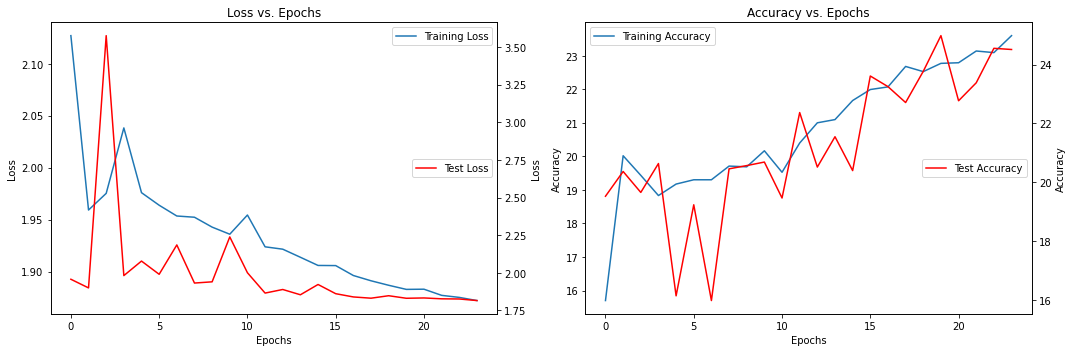

In [192]:
from utils import plot_loss_accuracy_graph_OneCLR
plot_loss_accuracy_graph_OneCLR(*history[0:4])

# Evaluating test Accuracy over different classes 

In [193]:
def calClassAccuracy(net, dataloader, classes, device):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images,labels = images.to(device),labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [194]:
#from utils import calAccuracy
calClassAccuracy(net, testloader, classes, device)

Accuracy of plane : 25 %
Accuracy of   car : 71 %
Accuracy of  bird :  0 %
Accuracy of   cat : 14 %
Accuracy of  deer :  0 %
Accuracy of   dog : 36 %
Accuracy of  frog : 80 %
Accuracy of horse :  0 %
Accuracy of  ship : 12 %
Accuracy of truck :  0 %


## Misclassified Images

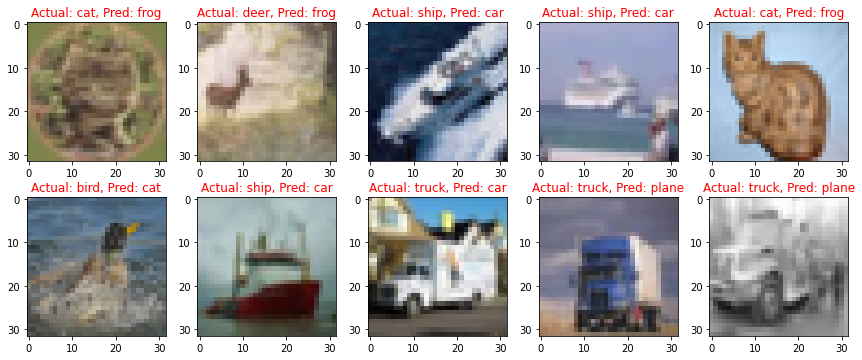

In [195]:
from utils import plot_misclassified_images
plot_misclassified_images(net, testloader, classes, device)